# Model Optimization with Hyperparameter Tuning and Cross-Validation

This notebook focuses on optimizing the baseline models using:
1. **Cross-Validation** for robust model evaluation
2. **Hyperparameter Tuning** using Grid Search and Random Search
3. **Advanced feature engineering** and selection
4. **Ensemble methods** for improved performance

The goal is to improve upon the baseline models (Logistic Regression, Gradient Boosted Trees, and Random Forest) while maintaining the time-based validation approach to prevent temporal leakage.

In [1]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofweek, hour, when, log1p, abs as abs_func, mean, stddev
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.window import Window
import pyspark.sql.functions as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [38]:
# Initialize Spark Session
import os
import sys

# Fix Python version mismatch by setting the Python executable explicitly
python_path = sys.executable
os.environ['PYSPARK_PYTHON'] = python_path
os.environ['PYSPARK_DRIVER_PYTHON'] = python_path

spark = SparkSession.builder \
    .appName("Fraud Detection Optimization") \
    .master("local[10]")\
    .config("spark.driver.memory", "16g")\
    .config("spark.driver.maxResultSize", "4g")\
    .config("spark.sql.shuffle.partitions", "10")\
    .config("spark.default.parallelism", "10")\
    .config("spark.sql.adaptive.enabled", "true")\
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")\
    .config("spark.pyspark.python", python_path) \
    .config("spark.pyspark.driver.python", python_path) \
    .getOrCreate()

print("Spark UI URL:", spark.sparkContext.uiWebUrl)
print("Spark Version:", spark.version)

Spark UI URL: http://192.168.1.5:4040
Spark Version: 4.1.0


## Data Loading and Enhanced Feature Engineering

In [3]:
# Load the enhanced feature dataset
input_path = "../data/features/fraud_features_v2.parquet"
df_model = spark.read.parquet(input_path)

print(f"Dataset shape: {df_model.count()} rows, {len(df_model.columns)} columns")
print(f"Fraud rate: {df_model.filter(col('TX_FRAUD') == 1).count() / df_model.count() * 100:.3f}%")

# Display schema
df_model.printSchema()
df_model.show(5)

Dataset shape: 1754155 rows, 9 columns
Fraud rate: 13.452%
root
 |-- TX_AMOUNT: double (nullable = true)
 |-- LOG_TX_AMOUNT: double (nullable = true)
 |-- TX_TIME_SECONDS: integer (nullable = true)
 |-- TX_TIME_DAYS: integer (nullable = true)
 |-- TX_HOUR: integer (nullable = true)
 |-- IS_NIGHT: integer (nullable = true)
 |-- IS_WEEKEND: integer (nullable = true)
 |-- TX_FRAUD: integer (nullable = true)
 |-- TX_DATE: date (nullable = true)

+---------+-----------------+---------------+------------+-------+--------+----------+--------+----------+
|TX_AMOUNT|    LOG_TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_HOUR|IS_NIGHT|IS_WEEKEND|TX_FRAUD|   TX_DATE|
+---------+-----------------+---------------+------------+-------+--------+----------+--------+----------+
|   533.07|6.280526916511479|             31|           0|      0|       1|         1|       0|2023-01-01|
|   808.56|6.696490890198005|            130|           0|      0|       1|         1|       0|2023-01-01|
|  1442.94|7.275130

In [4]:
# Create additional features for optimization
def create_advanced_features(df):
    """Create advanced features for model optimization"""
    
    # Amount-based features
    df = df.withColumn("TX_AMOUNT_LOG", log1p(col("TX_AMOUNT"))) \
           .withColumn("TX_AMOUNT_SQRT", F.sqrt(col("TX_AMOUNT"))) \
           .withColumn("TX_AMOUNT_SQUARED", col("TX_AMOUNT") * col("TX_AMOUNT"))
    
    # Time-based features (using TX_DATE since TX_DATETIME doesn't exist)
    df = df.withColumn("TX_DATETIME", F.to_timestamp(col("TX_DATE"))) \
           .withColumn("TX_MONTH", month(col("TX_DATE"))) \
           .withColumn("TX_DAYOFWEEK", dayofweek(col("TX_DATE"))) \
           .withColumn("TX_IS_MONTH_END", when(F.dayofmonth(col("TX_DATE")) >= 28, 1).otherwise(0)) \
           .withColumn("TX_IS_MONTH_START", when(F.dayofmonth(col("TX_DATE")) <= 3, 1).otherwise(0))
    
    # Interaction features
    df = df.withColumn("AMOUNT_TIME_INTERACTION", col("TX_AMOUNT") * col("TX_TIME_SECONDS")) \
           .withColumn("HOUR_WEEKEND_INTERACTION", col("TX_HOUR") * col("IS_WEEKEND"))
    
    return df

# Apply advanced feature engineering
df_enhanced = create_advanced_features(df_model)
print(f"Enhanced dataset: {len(df_enhanced.columns)} columns")

# Show new features
new_features = [col for col in df_enhanced.columns if col not in df_model.columns]
print(f"New features added: {new_features}")

df_enhanced.select(new_features[:5]).show(5)

Enhanced dataset: 19 columns
New features added: ['TX_AMOUNT_LOG', 'TX_AMOUNT_SQRT', 'TX_AMOUNT_SQUARED', 'TX_DATETIME', 'TX_MONTH', 'TX_DAYOFWEEK', 'TX_IS_MONTH_END', 'TX_IS_MONTH_START', 'AMOUNT_TIME_INTERACTION', 'HOUR_WEEKEND_INTERACTION']
+-----------------+------------------+------------------+-------------------+--------+
|    TX_AMOUNT_LOG|    TX_AMOUNT_SQRT| TX_AMOUNT_SQUARED|        TX_DATETIME|TX_MONTH|
+-----------------+------------------+------------------+-------------------+--------+
|6.280526916511479|23.088308729744586|284163.62490000005|2023-01-01 00:00:00|       1|
|6.696490890198005|28.435189466574684|       653769.2736|2023-01-01 00:00:00|       1|
|7.275130767342957| 37.98605007104582|2082075.8436000003|2023-01-01 00:00:00|       1|
|6.432377233398946|24.912848090894787|       385206.4225|2023-01-01 00:00:00|       1|
|6.197787420691848|22.150846484954023|       240747.2356|2023-01-01 00:00:00|       1|
+-----------------+------------------+------------------+---

In [5]:
# Enhanced feature list for optimization
enhanced_feature_cols = [
    # Original features
    "TX_AMOUNT",
    "LOG_TX_AMOUNT", 
    "TX_TIME_SECONDS",
    "TX_TIME_DAYS",
    "TX_HOUR", 
    "IS_NIGHT",
    "IS_WEEKEND",
    # New amount features
    "TX_AMOUNT_LOG",
    "TX_AMOUNT_SQRT",
    "TX_AMOUNT_SQUARED",
    # New time features
    "TX_MONTH",
    "TX_DAYOFWEEK", 
    "TX_IS_MONTH_END",
    "TX_IS_MONTH_START",
    # Interaction features
    "AMOUNT_TIME_INTERACTION",
    "HOUR_WEEKEND_INTERACTION"
]

print(f"Total features for optimization: {len(enhanced_feature_cols)}")

# Check for missing values
missing_summary = []
for col_name in enhanced_feature_cols:
    missing_count = df_enhanced.filter(col(col_name).isNull()).count()
    missing_summary.append((col_name, missing_count))

missing_df = pd.DataFrame(missing_summary, columns=['Feature', 'Missing_Count'])
print("Missing values summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

Total features for optimization: 16
Missing values summary:
Empty DataFrame
Columns: [Feature, Missing_Count]
Index: []


## Time-Based Data Splitting with Cross-Validation Strategy

For fraud detection, we need to be careful about temporal leakage. We'll use:
1. **Time-based split** for train/validation/test
2. **Time-series cross-validation** within the training period
3. **Walk-forward validation** to simulate real-world deployment

In [6]:
# Time-based data splitting (same as baseline but with enhanced features)
train_df = df_enhanced.filter(col("TX_DATE") < "2023-06-01")
val_df = df_enhanced.filter((col("TX_DATE") >= "2023-06-01") & (col("TX_DATE") < "2023-07-01"))  
test_df = df_enhanced.filter(col("TX_DATE") >= "2023-07-01")

print("=== Dataset Splits ===")
print(f"Train: {train_df.count():,} rows")
print(f"Val:   {val_df.count():,} rows") 
print(f"Test:  {test_df.count():,} rows")

# Check fraud distribution in each split
def check_fraud_distribution(df, split_name):
    total = df.count()
    fraud = df.filter(col("TX_FRAUD") == 1).count()
    fraud_rate = (fraud / total) * 100 if total > 0 else 0
    print(f"{split_name}: {fraud:,} fraud ({fraud_rate:.3f}%)")

print("\n=== Fraud Distribution ===")
check_fraud_distribution(train_df, "Train")
check_fraud_distribution(val_df, "Val")
check_fraud_distribution(test_df, "Test")

=== Dataset Splits ===
Train: 1,447,243 rows
Val:   287,840 rows
Test:  19,072 rows

=== Fraud Distribution ===
Train: 194,520 fraud (13.441%)
Val: 38,854 fraud (13.498%)
Test: 2,595 fraud (13.606%)


In [7]:
# Create time-series cross-validation splits within training data
def create_time_series_cv_splits(df, n_folds=5):
    """Create time-series CV splits to prevent temporal leakage"""
    
    # Get date range for training data
    min_date = df.select(F.min("TX_DATE")).collect()[0][0]
    max_date = df.select(F.max("TX_DATE")).collect()[0][0]
    
    print(f"Training data date range: {min_date} to {max_date}")
    
    # Calculate date ranges for each fold
    from datetime import datetime, timedelta
    
    # Convert to datetime for easier manipulation
    start_date = datetime.strptime(str(min_date), '%Y-%m-%d')
    end_date = datetime.strptime(str(max_date), '%Y-%m-%d') 
    total_days = (end_date - start_date).days
    
    fold_size = total_days // (n_folds + 1)  # +1 to ensure we have enough data for validation
    
    cv_splits = []
    for i in range(n_folds):
        # Training period: start_date + i * fold_size days  
        train_start = start_date + timedelta(days=i * fold_size // 2)  # Overlapping training periods
        train_end = start_date + timedelta(days=(i + n_folds) * fold_size // n_folds)
        
        # Validation period: next fold_size days
        val_start = train_end
        val_end = min(val_start + timedelta(days=fold_size), end_date)
        
        cv_splits.append({
            'train_start': train_start.strftime('%Y-%m-%d'),
            'train_end': train_end.strftime('%Y-%m-%d'), 
            'val_start': val_start.strftime('%Y-%m-%d'),
            'val_end': val_end.strftime('%Y-%m-%d')
        })
    
    return cv_splits

# Create CV splits
cv_splits = create_time_series_cv_splits(train_df, n_folds=3)

print("\n=== Cross-Validation Splits ===")
for i, split in enumerate(cv_splits):
    print(f"Fold {i+1}:")
    print(f"  Train: {split['train_start']} to {split['train_end']}")
    print(f"  Val:   {split['val_start']} to {split['val_end']}")
    
    # Check actual data counts
    fold_train = train_df.filter(
        (col("TX_DATE") >= split['train_start']) & 
        (col("TX_DATE") < split['train_end'])
    )
    fold_val = train_df.filter(
        (col("TX_DATE") >= split['val_start']) & 
        (col("TX_DATE") < split['val_end'])
    )
    
    print(f"  Train count: {fold_train.count():,}")
    print(f"  Val count:   {fold_val.count():,}")
    print()

Training data date range: 2023-01-01 to 2023-05-31

=== Cross-Validation Splits ===
Fold 1:
  Train: 2023-01-01 to 2023-02-07
  Val:   2023-02-07 to 2023-03-16
  Train count: 355,270
  Val count:   354,357

Fold 2:
  Train: 2023-01-19 to 2023-02-19
  Val:   2023-02-19 to 2023-03-28
  Train count: 297,988
  Val count:   354,200

Fold 3:
  Train: 2023-02-07 to 2023-03-03
  Val:   2023-03-03 to 2023-04-09
  Train count: 229,907
  Val count:   355,135



## Hyperparameter Tuning with Cross-Validation

We'll optimize each model using:
1. **ParamGridBuilder** for systematic grid search
2. **CrossValidator** with time-aware splitting
3. **Multiple evaluation metrics** (AUC, Precision-Recall AUC)
4. **Class balancing** techniques

In [8]:
# Setup common pipeline components
assembler = VectorAssembler(
    inputCols=enhanced_feature_cols,
    outputCol="features"
)

# Multiple scalers for testing
standard_scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features", 
    withMean=True,
    withStd=True
)

minmax_scaler = MinMaxScaler(
    inputCol="features",
    outputCol="minmax_features"
)

# Setup evaluators
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="TX_FRAUD",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

pr_evaluator = BinaryClassificationEvaluator(
    labelCol="TX_FRAUD", 
    rawPredictionCol="rawPrediction",
    metricName="areaUnderPR"
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="TX_FRAUD",
    predictionCol="prediction",
    metricName="accuracy"
)

print("Pipeline components initialized successfully!")

Pipeline components initialized successfully!


### 1. Logistic Regression Optimization

In [ ]:
# Logistic Regression hyperparameter tuning
def tune_logistic_regression():
    """Tune Logistic Regression with cross-validation"""
    
    print("=== Tuning Logistic Regression ===")
    
    # Create logistic regression classifier
    lr = LogisticRegression(
        featuresCol="scaled_features",
        labelCol="TX_FRAUD",
        maxIter=100
    )
    
    # Create pipeline
    lr_pipeline = Pipeline(stages=[assembler, standard_scaler, lr])
    
    # Parameter grid
    lr_param_grid = (ParamGridBuilder()
                    .addGrid(lr.regParam, [0.001, 0.01, 0.1, 1.0])
                    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 0.9, 1.0])
                    .addGrid(lr.threshold, [0.3, 0.4, 0.5, 0.6, 0.7])
                    .build())
    
    print(f"Total parameter combinations: {len(lr_param_grid)}")
    
    # Cross-validator
    cv = CrossValidator(
        estimator=lr_pipeline,
        estimatorParamMaps=lr_param_grid,
        evaluator=auc_evaluator,
        numFolds=3,
        seed=42,
        parallelism=2  # Adjust based on your cluster capacity
    )
    
    # Fit the model
    print("Starting cross-validation... This may take a while.")
    cv_model = cv.fit(train_df)
    
    # Get best model
    best_lr_model = cv_model.bestModel
    
    # Evaluate on validation set
    val_predictions = best_lr_model.transform(val_df)
    
    # Calculate metrics
    auc_score = auc_evaluator.evaluate(val_predictions)
    pr_score = pr_evaluator.evaluate(val_predictions)
    accuracy = accuracy_evaluator.evaluate(val_predictions)
    
    print(f"\n=== Best Logistic Regression Results ===")
    print(f"Validation AUC: {auc_score:.4f}")
    print(f"Validation PR-AUC: {pr_score:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    # Get best parameters
    best_lr = best_lr_model.stages[-1]
    print(f"\nBest Parameters:")
    print(f"  regParam: {best_lr.getRegParam}")
    print(f"  elasticNetParam: {best_lr.getElasticNetParam}")
    print(f"  threshold: {best_lr.getThreshold}")
    
    # Show prediction distribution
    pred_dist = val_predictions.groupBy("TX_FRAUD", "prediction").count().orderBy("TX_FRAUD", "prediction")
    print(f"\nPrediction Distribution:")
    pred_dist.show()
    
    return cv_model, val_predictions

# Run LR tuning
lr_cv_model, lr_val_predictions = tune_logistic_regression()

=== Tuning Logistic Regression ===
Total parameter combinations: 100
Starting cross-validation... This may take a while.


26/01/12 00:32:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
26/01/12 00:32:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS



=== Best Logistic Regression Results ===
Validation AUC: 0.9809
Validation PR-AUC: 0.9735
Validation Accuracy: 0.9905

Best Parameters:
  regParam: 0.001
  elasticNetParam: 1.0
  threshold: 0.5

Prediction Distribution:
+--------+----------+------+
|TX_FRAUD|prediction| count|
+--------+----------+------+
|       0|       0.0|248986|
|       1|       0.0|  2724|
|       1|       1.0| 36130|
+--------+----------+------+



### 2. Random Forest Optimization

In [24]:
# Random Forest hyperparameter tuning
def tune_random_forest():
    """Tune Random Forest with cross-validation"""
    
    print("=== Tuning Random Forest ===")
    
    # Create random forest classifier
    rf = RandomForestClassifier(
        featuresCol="features",
        labelCol="TX_FRAUD",
        seed=42
    )
    
    # Create pipeline (RF doesn't need scaling)
    rf_pipeline = Pipeline(stages=[assembler, rf])
    
    # Parameter grid
    rf_param_grid = (ParamGridBuilder()
                    .addGrid(rf.numTrees, [50, 100])
                    .addGrid(rf.maxDepth, [1, 5, 10])
                    .addGrid(rf.minInstancesPerNode, [1, 5])
                    .addGrid(rf.subsamplingRate, [0.8, 1.0])
                    .build())
    
    print(f"Total parameter combinations: {len(rf_param_grid)}")
    
    # Use TrainValidationSplit for faster tuning (instead of full CV)
    tvs = TrainValidationSplit(
        estimator=rf_pipeline,
        estimatorParamMaps=rf_param_grid,
        evaluator=auc_evaluator,
        trainRatio=0.8,
        seed=42,
        parallelism=2
    )
    
    # Fit the model
    print("Starting train-validation split tuning... This may take a while.")
    tvs_model = tvs.fit(train_df)
    
    # Get best model
    best_rf_model = tvs_model.bestModel
    
    # Evaluate on validation set
    val_predictions = best_rf_model.transform(val_df)
    
    # Calculate metrics
    auc_score = auc_evaluator.evaluate(val_predictions)
    pr_score = pr_evaluator.evaluate(val_predictions)
    accuracy = accuracy_evaluator.evaluate(val_predictions)
    
    print(f"\n=== Best Random Forest Results ===")
    print(f"Validation AUC: {auc_score:.4f}")
    print(f"Validation PR-AUC: {pr_score:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    # Get best parameters
    best_rf = best_rf_model.stages[-1]
    print(f"\nBest Parameters:")
    print(f"  numTrees: {best_rf.getNumTrees}")
    print(f"  maxDepth: {best_rf.getMaxDepth}")
    print(f"  minInstancesPerNode: {best_rf.getMinInstancesPerNode}")
    print(f"  subsamplingRate: {best_rf.getSubsamplingRate}")
    
    # Feature importance
    try:
        feature_importance = best_rf.featureImportances
        importance_list = [(enhanced_feature_cols[i], float(feature_importance[i])) 
                          for i in range(len(enhanced_feature_cols))]
        importance_list.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\nTop 10 Feature Importances:")
        for feature, importance in importance_list[:10]:
            print(f"  {feature}: {importance:.4f}")
    except Exception as e:
        print(f"Could not extract feature importance: {e}")
    
    # Show prediction distribution
    pred_dist = val_predictions.groupBy("TX_FRAUD", "prediction").count().orderBy("TX_FRAUD", "prediction")
    print(f"\nPrediction Distribution:")
    pred_dist.show()
    
    return tvs_model, val_predictions

# Run RF tuning
rf_tvs_model, rf_val_predictions = tune_random_forest()

=== Tuning Random Forest ===
Total parameter combinations: 24
Starting train-validation split tuning... This may take a while.


Py4JJavaError: An error occurred while calling o721492.persist.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:59)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:481)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
py4j.ClientServerConnection.run(ClientServerConnection.java:108)
java.base/java.lang.Thread.run(Thread.java:840)

And it was stopped at:

org.apache.spark.api.java.JavaSparkContext.stop(JavaSparkContext.scala:552)
java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
java.base/java.lang.reflect.Method.invoke(Method.java:569)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:282)
py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
py4j.commands.CallCommand.execute(CallCommand.java:79)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
py4j.ClientServerConnection.run(ClientServerConnection.java:108)
java.base/java.lang.Thread.run(Thread.java:840)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:59)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:481)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
py4j.ClientServerConnection.run(ClientServerConnection.java:108)
java.base/java.lang.Thread.run(Thread.java:840)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:128)
	at org.apache.spark.sql.classic.SparkSession.<init>(SparkSession.scala:125)
	at org.apache.spark.sql.classic.SparkSession.cloneSession(SparkSession.scala:266)
	at org.apache.spark.sql.classic.SparkSession$.getOrCloneSessionWithConfigsOff(SparkSession.scala:1113)
	at org.apache.spark.sql.execution.CacheManager.getOrCloneSessionWithConfigsOff(CacheManager.scala:621)
	at org.apache.spark.sql.execution.CacheManager.cacheQueryInternal(CacheManager.scala:149)
	at org.apache.spark.sql.execution.CacheManager.cacheQuery(CacheManager.scala:115)
	at org.apache.spark.sql.classic.Dataset.persist(Dataset.scala:1578)
	at org.apache.spark.sql.classic.Dataset.persist(Dataset.scala:231)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)


### 3. Gradient Boosted Trees Optimization

In [ ]:
# Gradient Boosted Trees hyperparameter tuning
def tune_gradient_boosted_trees():
    """Tune GBT with cross-validation"""
    
    print("=== Tuning Gradient Boosted Trees ===")
    
    # Create GBT classifier
    gbt = GBTClassifier(
        featuresCol="features",
        labelCol="TX_FRAUD",
        seed=42
    )
    
    # Create pipeline (GBT doesn't need scaling)
    gbt_pipeline = Pipeline(stages=[assembler, gbt])
    
    # Parameter grid (smaller grid for GBT due to longer training time)
    gbt_param_grid = (ParamGridBuilder()
                     .addGrid(gbt.maxIter, [50, 100])
                     .addGrid(gbt.maxDepth, [4, 6])
                     .addGrid(gbt.stepSize, [0.05, 0.1])
                     .addGrid(gbt.subsamplingRate, [0.8, 1.0])
                     .build())
    
    print(f"Total parameter combinations: {len(gbt_param_grid)}")
    
    # Use TrainValidationSplit for faster tuning
    tvs = TrainValidationSplit(
        estimator=gbt_pipeline,
        estimatorParamMaps=gbt_param_grid,
        evaluator=auc_evaluator,
        trainRatio=0.8,
        seed=42,
        parallelism=1  # GBT is more memory intensive
    )
    
    # Fit the model
    print("Starting train-validation split tuning... This will take longer.")
    tvs_model = tvs.fit(train_df)
    
    # Get best model
    best_gbt_model = tvs_model.bestModel
    
    # Evaluate on validation set
    val_predictions = best_gbt_model.transform(val_df)
    
    # Calculate metrics
    auc_score = auc_evaluator.evaluate(val_predictions)
    pr_score = pr_evaluator.evaluate(val_predictions)
    accuracy = accuracy_evaluator.evaluate(val_predictions)
    
    print(f"\n=== Best Gradient Boosted Trees Results ===")
    print(f"Validation AUC: {auc_score:.4f}")
    print(f"Validation PR-AUC: {pr_score:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    # Get best parameters
    best_gbt = best_gbt_model.stages[-1]
    print(f"\nBest Parameters:")
    print(f"  maxIter: {best_gbt.getMaxIter}")
    print(f"  maxDepth: {best_gbt.getMaxDepth}")
    print(f"  stepSize: {best_gbt.getStepSize}")
    print(f"  subsamplingRate: {best_gbt.getSubsamplingRate}")
    
    # Feature importance
    try:
        feature_importance = best_gbt.featureImportances
        importance_list = [(enhanced_feature_cols[i], float(feature_importance[i])) 
                          for i in range(len(enhanced_feature_cols))]
        importance_list.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\nTop 10 Feature Importances:")
        for feature, importance in importance_list[:10]:
            print(f"  {feature}: {importance:.4f}")
    except Exception as e:
        print(f"Could not extract feature importance: {e}")
    
    # Show prediction distribution
    pred_dist = val_predictions.groupBy("TX_FRAUD", "prediction").count().orderBy("TX_FRAUD", "prediction")
    print(f"\nPrediction Distribution:")
    pred_dist.show()
    
    return tvs_model, val_predictions

# Run GBT tuning
gbt_tvs_model, gbt_val_predictions = tune_gradient_boosted_trees()

=== Tuning Gradient Boosted Trees ===
Total parameter combinations: 16
Starting train-validation split tuning... This will take longer.


26/01/12 08:18:38 WARN DAGScheduler: Broadcasting large task binary with size 1693.5 KiB
26/01/12 08:18:43 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
26/01/12 08:18:49 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
26/01/12 08:18:56 WARN DAGScheduler: Broadcasting large task binary with size 1008.4 KiB
26/01/12 08:19:01 WARN DAGScheduler: Broadcasting large task binary with size 1694.6 KiB
26/01/12 08:19:05 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
26/01/12 08:19:11 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
26/01/12 08:19:18 WARN DAGScheduler: Broadcasting large task binary with size 1027.7 KiB
26/01/12 08:19:30 WARN DAGScheduler: Broadcasting large task binary with size 1679.3 KiB
26/01/12 08:19:36 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
26/01/12 08:19:41 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
26/01/12 08:19:58 WARN DAGScheduler: Br


=== Best Gradient Boosted Trees Results ===
Validation AUC: 0.9806
Validation PR-AUC: 0.9716
Validation Accuracy: 0.9912

Best Parameters:
  maxIter: <bound method HasMaxIter.getMaxIter of GBTClassificationModel: uid = GBTClassifier_2f91bd11effc, numTrees=100, numClasses=2, numFeatures=16>
  maxDepth: <bound method _DecisionTreeParams.getMaxDepth of GBTClassificationModel: uid = GBTClassifier_2f91bd11effc, numTrees=100, numClasses=2, numFeatures=16>
  stepSize: <bound method HasStepSize.getStepSize of GBTClassificationModel: uid = GBTClassifier_2f91bd11effc, numTrees=100, numClasses=2, numFeatures=16>
  subsamplingRate: <bound method _TreeEnsembleParams.getSubsamplingRate of GBTClassificationModel: uid = GBTClassifier_2f91bd11effc, numTrees=100, numClasses=2, numFeatures=16>

Top 10 Feature Importances:
  LOG_TX_AMOUNT: 0.9691
  TX_AMOUNT: 0.0213
  AMOUNT_TIME_INTERACTION: 0.0065
  TX_TIME_SECONDS: 0.0009
  TX_AMOUNT_SQUARED: 0.0009
  TX_TIME_DAYS: 0.0008
  TX_MONTH: 0.0004
  TX_DAYOF

26/01/12 10:30:17 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
26/01/12 10:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1003.2 KiB
26/01/12 10:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1004.2 KiB
26/01/12 10:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1004.8 KiB
26/01/12 10:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1005.6 KiB
26/01/12 10:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1007.9 KiB
26/01/12 10:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
26/01/12 10:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1021.7 KiB
26/01/12 10:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1025.2 KiB
26/01/12 10:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1025.7 KiB
26/01/12 10:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1026.7 KiB
26/01/12 10:30:18 WAR

## Model Comparison and Analysis

In [15]:
# Model comparison function
def compare_optimized_models():
    """Compare all optimized models"""
    
    print("=== Optimized Model Comparison ===")
    
    # Evaluate all models on validation set
    models_info = [
        ("Logistic Regression", lr_cv_model.bestModel, lr_val_predictions),
        ("Random Forest", rf_tvs_model.bestModel, rf_val_predictions),  
        ("Gradient Boosted Trees", gbt_tvs_model.bestModel, gbt_val_predictions)
    ]
    
    results = []
    
    for name, model, predictions in models_info:
        # Calculate metrics
        auc = auc_evaluator.evaluate(predictions)
        pr_auc = pr_evaluator.evaluate(predictions)
        accuracy = accuracy_evaluator.evaluate(predictions)
        
        # Calculate additional metrics manually
        tp = predictions.filter((col("TX_FRAUD") == 1) & (col("prediction") == 1)).count()
        fp = predictions.filter((col("TX_FRAUD") == 0) & (col("prediction") == 1)).count() 
        tn = predictions.filter((col("TX_FRAUD") == 0) & (col("prediction") == 0)).count()
        fn = predictions.filter((col("TX_FRAUD") == 1) & (col("prediction") == 0)).count()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results.append({
            'Model': name,
            'AUC': auc,
            'PR-AUC': pr_auc,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn
        })
    
    # Convert to pandas for better display
    results_df = pd.DataFrame(results)
    print("\nModel Performance Summary:")
    print("=" * 80)
    for _, row in results_df.iterrows():
        print(f"\n{row['Model']}:")
        print(f"  AUC: {row['AUC']:.4f}")
        print(f"  PR-AUC: {row['PR-AUC']:.4f}") 
        print(f"  Accuracy: {row['Accuracy']:.4f}")
        print(f"  Precision: {row['Precision']:.4f}")
        print(f"  Recall: {row['Recall']:.4f}")
        print(f"  F1-Score: {row['F1-Score']:.4f}")
        print(f"  Confusion Matrix: TP={row['TP']}, FP={row['FP']}, TN={row['TN']}, FN={row['FN']}")
    
    return results_df

# Run comparison
results_comparison = compare_optimized_models()

=== Optimized Model Comparison ===



Model Performance Summary:

Logistic Regression:
  AUC: 0.9809
  PR-AUC: 0.9735
  Accuracy: 0.9905
  Precision: 1.0000
  Recall: 0.9299
  F1-Score: 0.9637
  Confusion Matrix: TP=36130, FP=0, TN=248986, FN=2724

Random Forest:
  AUC: 0.9805
  PR-AUC: 0.9708
  Accuracy: 0.9912
  Precision: 1.0000
  Recall: 0.9350
  F1-Score: 0.9664
  Confusion Matrix: TP=36330, FP=0, TN=248986, FN=2524

Gradient Boosted Trees:
  AUC: 0.9806
  PR-AUC: 0.9716
  Accuracy: 0.9912
  Precision: 1.0000
  Recall: 0.9350
  F1-Score: 0.9664
  Confusion Matrix: TP=36330, FP=0, TN=248986, FN=2524


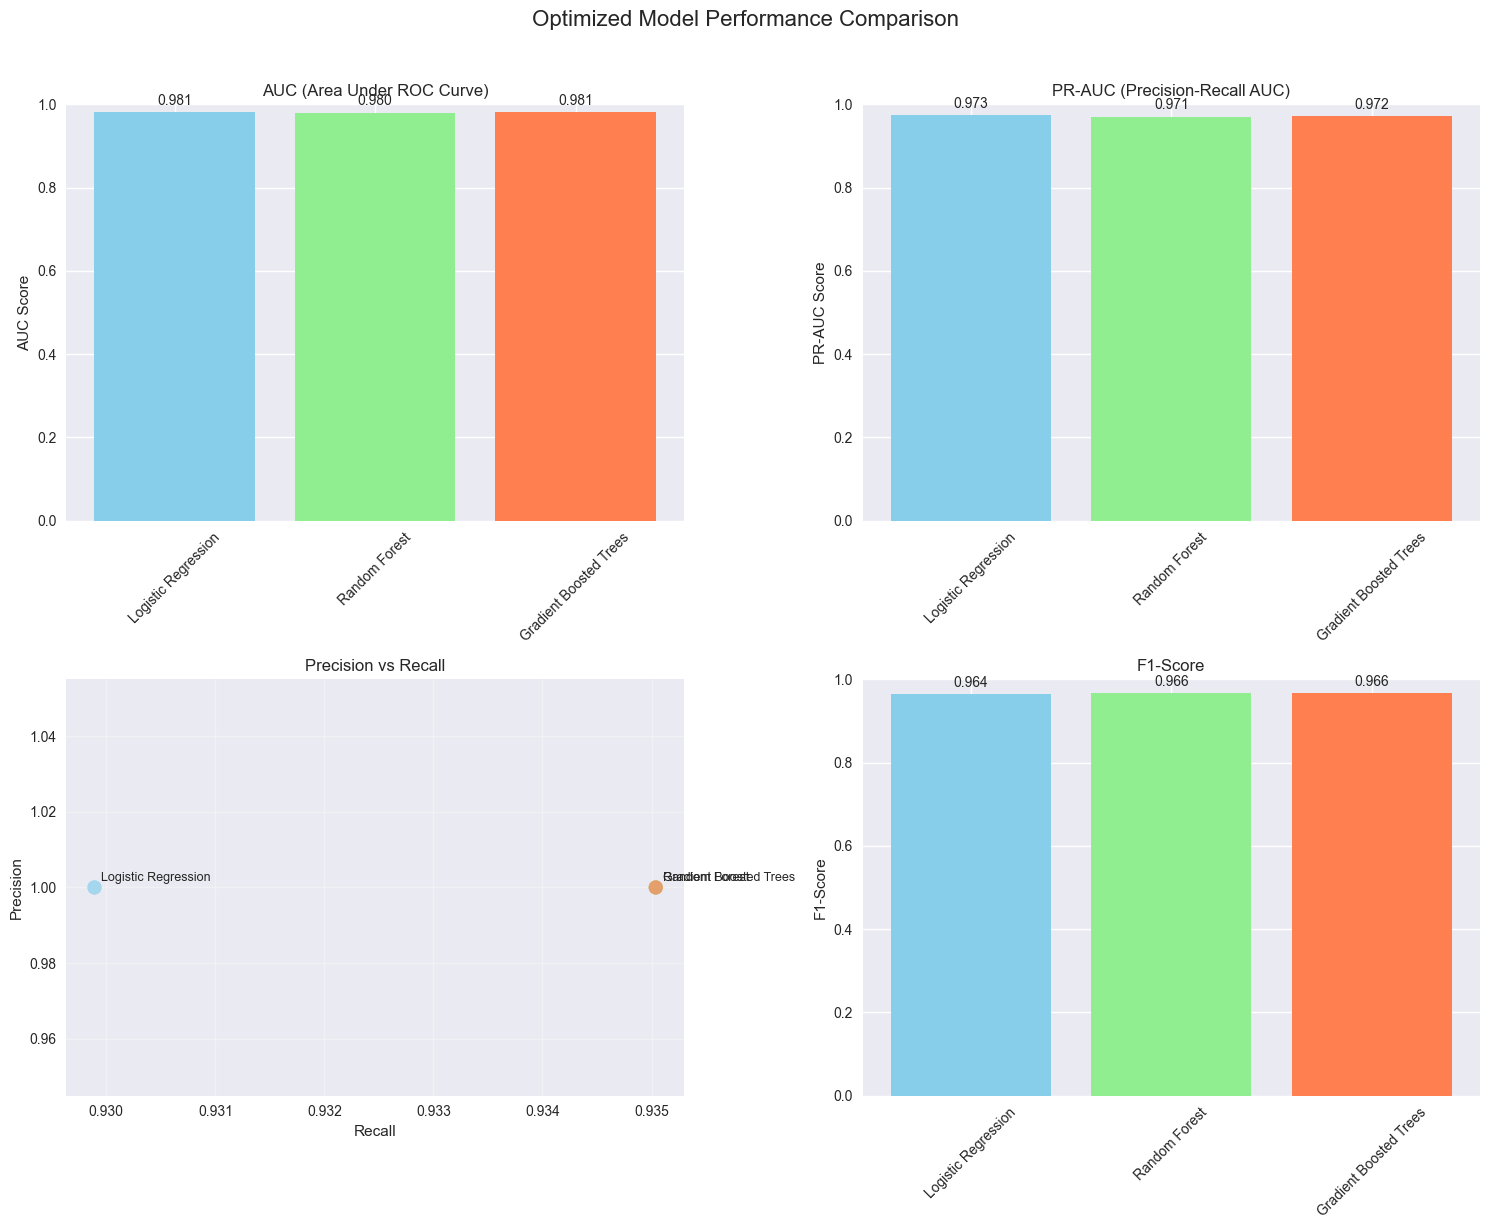

In [16]:
# Visualize model comparison
def plot_model_comparison(results_df):
    """Create comparison plots for optimized models"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Optimized Model Performance Comparison', fontsize=16, y=1.02)
    
    # AUC comparison
    axes[0,0].bar(results_df['Model'], results_df['AUC'], color=['skyblue', 'lightgreen', 'coral'])
    axes[0,0].set_title('AUC (Area Under ROC Curve)')
    axes[0,0].set_ylabel('AUC Score')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].set_ylim(0, 1)
    
    # Add value labels on bars
    for i, v in enumerate(results_df['AUC']):
        axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # PR-AUC comparison  
    axes[0,1].bar(results_df['Model'], results_df['PR-AUC'], color=['skyblue', 'lightgreen', 'coral'])
    axes[0,1].set_title('PR-AUC (Precision-Recall AUC)')
    axes[0,1].set_ylabel('PR-AUC Score')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].set_ylim(0, 1)
    
    for i, v in enumerate(results_df['PR-AUC']):
        axes[0,1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # Precision vs Recall
    axes[1,0].scatter(results_df['Recall'], results_df['Precision'], 
                     s=100, c=['skyblue', 'lightgreen', 'coral'], alpha=0.7)
    for i, model in enumerate(results_df['Model']):
        axes[1,0].annotate(model, (results_df['Recall'].iloc[i], results_df['Precision'].iloc[i]),
                          xytext=(5, 5), textcoords='offset points', fontsize=9)
    axes[1,0].set_xlabel('Recall')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].set_title('Precision vs Recall')
    axes[1,0].grid(True, alpha=0.3)
    
    # F1-Score comparison
    axes[1,1].bar(results_df['Model'], results_df['F1-Score'], color=['skyblue', 'lightgreen', 'coral'])
    axes[1,1].set_title('F1-Score')
    axes[1,1].set_ylabel('F1-Score')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].set_ylim(0, 1)
    
    for i, v in enumerate(results_df['F1-Score']):
        axes[1,1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Create comparison plots
plot_model_comparison(results_comparison)